In [16]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [17]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

X_train = train_df.drop(['Label', 'Attack'], axis=1)
y_train = train_df['Attack'] 

X_eval = eval_df.drop(['Label', 'Attack'], axis=1)
y_eval = eval_df['Attack']

X_test = test_df.drop(['Label', 'Attack'], axis=1)
y_test = test_df['Attack']

# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [61]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it to a specified filename."""
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    dump(model, filename)
    return model, training_time

def optimize_threshold(model, X, y, beta=2):
    start_time = time.time()
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)
    best_threshold = thresholds[best_idx]
    optimization_time = time.time() - start_time
    return best_threshold, optimization_time

def evaluate_and_save(model, y, predictions, probabilities, best_threshold, model_name, feature_subset,
                    training_time, optimization_time, batch_prediction_time, single_instance_prediction_time):
    start_time = time.time()
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec + rec))
    roc_auc = roc_auc_score(y, probabilities)
    evaluation_time = time.time() - start_time

    # appending results
    performances.append({
        'model': model_name, 'features': feature_subset, 'n-features': len(feature_subset), 'threshold': best_threshold, 
        'accuracy': acc,'precision': prec,'recall': rec, 'f1': f1,'f2': f2,'roc_auc': roc_auc,
        'training_time': training_time, 'optimization_time': optimization_time, 'evaluation_time': evaluation_time,
        'batch_prediction_time': batch_prediction_time, 'single_instance_prediction_time': single_instance_prediction_time})
    
    report = classification_report(y, predictions)
    cm = confusion_matrix(y, predictions)

    # Save the classification report as TXT
    report_path = f'../output/best_models_evaluation/{model_name}_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    # Generate and save onfusion matrix as JPEG
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    
    matrix_path = f'../output/best_models_evaluation/{model_name}_confusion_matrix.jpeg'
    plt.savefig(matrix_path)
    plt.close(fig)
    print(f"Saved results for {model_name} at {matrix_path}")
    return

def process_model(model, feature_subset, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Subset the features for the different datasets
    X_train_subset = X_train[feature_subset]
    X_val_subset = X_val[feature_subset]
    X_test_subset = X_test[feature_subset]

    # Train the model
    filename = f"../models/best_models/{model_name}_model.joblib"
    trained_model, training_time = train_and_save(model, X_train_subset, y_train, filename)

    # Optimize threshold on validation set
    best_threshold, optimization_time = optimize_threshold(trained_model, X_val_subset, y_val)

    # Measure prediction time for a single batch
    batch_start_time = time.time()
    # Apply model to the test set using the optimized threshold
    probabilities = trained_model.predict_proba(X_test_subset)[:, 1]
    predictions = (probabilities >= best_threshold).astype(int)
    batch_prediction_time = time.time() - batch_start_time

    # Measure prediction time for a single instance
    single_instance_start_time = time.time()
    _ = trained_model.predict_proba(X_test_subset)[0, 1]
    _ = (probabilities >= best_threshold).astype(int)
    single_instance_prediction_time = time.time() - single_instance_start_time

    # create predictions and save results
    evaluate_and_save(trained_model, y_test, predictions, probabilities, best_threshold, model_name,
                         feature_subset, training_time, optimization_time, batch_prediction_time, single_instance_prediction_time)
    return predictions

In [62]:
models = {
    'Default_RF': RandomForestClassifier(n_estimators=100, random_state=42),

    'Tuned_RF': RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42),
    'Tuned_RFall': RandomForestClassifier(n_estimators=100, max_depth = None, min_samples_leaf=2,
                                        min_samples_split = 2, random_state=42),

    'Default_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False),

    'Tuned_XGB': XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=0.5,learning_rate=0.3, max_depth=10,
                                n_estimators=350, subsample=0.5, eval_metric='logloss'),
                                
    'Tuned_XGBall': XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=1,learning_rate=0.3, max_depth=3,
                                n_estimators=300, subsample=0.7, eval_metric='logloss')
}

selected_features = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                              'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                              'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
                              'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

xgb_features_rfecv = ['Protocol', 'Flow Duration', 'Total Fwd Packets','Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max','Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max','Bwd Packet Length Min', 'Bwd Packet Length Mean','Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min','Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Fwd PSH Flags','Fwd Header Length', 'Bwd Header Length', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std','PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Avg Packet Size', 'Init Fwd Win Bytes','Init Bwd Win Bytes', 'Fwd Act Data Packets', 'Fwd Seg Size Min',
       'Active Std', 'Active Min', 'Idle Mean']

xgb_features_perm = ['Protocol','Flow Duration','Total Backward Packets','Fwd Packets Length Total','Fwd Packet Length Max','Fwd Packet Length Mean',
 'Bwd Packet Length Max','Bwd Packet Length Mean','Bwd Packet Length Std','Flow Bytes/s','Flow IAT Std','Flow IAT Max','Flow IAT Min','Fwd IAT Total',
 'Fwd IAT Mean','Fwd IAT Std','Fwd IAT Min','Bwd IAT Std','Bwd IAT Max','Fwd PSH Flags','Fwd Header Length','Bwd Header Length','Bwd Packets/s',
 'Packet Length Max','Packet Length Std','FIN Flag Count','ACK Flag Count','URG Flag Count','Down/Up Ratio','Avg Packet Size','Init Fwd Win Bytes',
 'Init Bwd Win Bytes','Fwd Act Data Packets','Fwd Seg Size Min','Active Max','Idle Mean','Idle Max','Idle Min']

all_features = [col for col in X_train.columns]

models_config = {
    'Default_RF_All_Features': all_features,
    'Tuned_RFall_Features': all_features,
    'Default_RF_selected_Features': selected_features,
    'Tuned_RF_selected_Features': selected_features,
    'Tuned_RF_Permutation_Features': ['Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd Packets Length Total',
                                   'Packet Length Mean', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size',
                                   'Avg Bwd Segment Size'],

    'Default_XGB_All_Features': all_features,
    'Tuned_XGBall_Features': all_features,
    'Tuned_XGBall_RFECV_Features': xgb_features_rfecv,
    'Tuned_XGBall_permutation_Features': xgb_features_perm,                           
    'Default_XGB_selected_Features': selected_features,
    'Tuned_XGB_selected_Features': selected_features,
    'Tuned_XGB_Permutation_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                       'Packet Length Std', 'Avg Packet Size', 'Fwd Header Length'],
    'Tuned_XGB_RFECV_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                                 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size']
}


In [63]:
# fror validation results, with optimized threshold
all_predictions = test_df
performances = []

# Iterating over configurations
for model_name, features in models_config.items():
    # Extract the base model name (before the underscore)
    base_model_name = '_'.join(model_name.split('_')[:2])
    print(f'\n running {model_name} with {len(features)} and base model {base_model_name}')                  # using eval here
    predictions = process_model(models[base_model_name], features, X_train, y_train, X_eval, y_eval, X_eval, y_eval, model_name)
 


 running Default_RF_All_Features with 77 and base model Default_RF
Saved results for Default_RF_All_Features at ../output/best_models_evaluation/Default_RF_All_Features_confusion_matrix.jpeg

 running Tuned_RFall_Features with 77 and base model Tuned_RFall
Saved results for Tuned_RFall_Features at ../output/best_models_evaluation/Tuned_RFall_Features_confusion_matrix.jpeg

 running Default_RF_selected_Features with 14 and base model Default_RF
Saved results for Default_RF_selected_Features at ../output/best_models_evaluation/Default_RF_selected_Features_confusion_matrix.jpeg

 running Tuned_RF_selected_Features with 14 and base model Tuned_RF
Saved results for Tuned_RF_selected_Features at ../output/best_models_evaluation/Tuned_RF_selected_Features_confusion_matrix.jpeg

 running Tuned_RF_Permutation_Features with 8 and base model Tuned_RF
Saved results for Tuned_RF_Permutation_Features at ../output/best_models_evaluation/Tuned_RF_Permutation_Features_confusion_matrix.jpeg

 running D

In [64]:
val_results_df = pd.DataFrame(performances)
val_results_df['split'] = 'Val'
val_results_df         

,model,features,n-features,threshold,accuracy,precision,recall,f1,f2,roc_auc,training_time,optimization_time,evaluation_time,batch_prediction_time,single_instance_prediction_time,split
0,Default_RF_All_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",77,0.540000,0.997067,0.985203,0.995315,0.990233,0.993276,0.999842,10.625539,0.181745,0.054515,0.176112,0.177042,Val
1,Tuned_RFall_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",77,0.576685,0.997500,0.988256,0.995091,0.991662,0.993717,0.999911,10.582115,0.185801,0.056618,0.177883,0.180656,Val
2,Default_RF_selected_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",14,0.780000,0.992833,0.964511,0.988398,0.976309,0.983526,0.997880,5.845283,0.156271,0.056372,0.155765,0.164041,Val
3,Tuned_RF_selected_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",14,0.629748,0.992200,0.958549,0.990629,0.974325,0.984043,0.998995,6.112633,0.172452,0.057717,0.164581,0.173424,Val
4,Tuned_RF_Permutation_Features,"[Fwd IAT Total, Bwd Packet Length Std, Bwd Pac...",8,0.610204,0.992033,0.957713,0.990406,0.973785,0.983690,0.998933,4.452441,0.176191,0.065075,0.182096,0.161907,Val
5,Default_XGB_All_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",77,0.538581,0.997933,0.988722,0.997546,0.993114,0.995768,0.999938,0.970660,0.045624,0.054484,0.039340,0.038558,Val
6,Tuned_XGBall_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",77,0.568905,0.997833,0.988282,0.997323,0.992782,0.995501,0.999942,1.835472,0.042994,0.055711,0.037310,0.037146,Val
7,Tuned_XGBall_RFECV_Features,"[Protocol, Flow Duration, Total Fwd Packets, T...",46,0.506189,0.997733,0.987196,0.997769,0.992455,0.995636,0.999940,1.015392,0.041770,0.063105,0.032183,0.031341,Val
8,Tuned_XGBall_permutation_Features,"[Protocol, Flow Duration, Total Backward Packe...",38,0.590125,0.998067,0.990683,0.996430,0.993548,0.995275,0.999930,0.893470,0.039082,0.055931,0.029806,0.031083,Val
9,Default_XGB_selected_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",14,0.877578,0.995467,0.986565,0.983043,0.984801,0.983746,0.999425,0.320618,0.035548,0.060322,0.028221,0.027376,Val


In [65]:
# for test results, with threshold from val set
all_predictions = test_df
performances = []

# Iterating over configurations
for model_name, features in models_config.items():
    # Extract the base model name (before the underscore)
    base_model_name = '_'.join(model_name.split('_')[:2])
    print(f'\n running {model_name} with {len(features)} and base model {base_model_name}')                  # back to test
    predictions = process_model(models[base_model_name], features, X_train, y_train, X_eval, y_eval, X_test, y_test, model_name)
    # Add predictions to the DataFrame
    all_predictions[f'{model_name}_Predictions'] = predictions


 running Default_RF_All_Features with 77 and base model Default_RF
Saved results for Default_RF_All_Features at ../output/best_models_evaluation/Default_RF_All_Features_confusion_matrix.jpeg

 running Tuned_RFall_Features with 77 and base model Tuned_RFall
Saved results for Tuned_RFall_Features at ../output/best_models_evaluation/Tuned_RFall_Features_confusion_matrix.jpeg

 running Default_RF_selected_Features with 14 and base model Default_RF
Saved results for Default_RF_selected_Features at ../output/best_models_evaluation/Default_RF_selected_Features_confusion_matrix.jpeg

 running Tuned_RF_selected_Features with 14 and base model Tuned_RF
Saved results for Tuned_RF_selected_Features at ../output/best_models_evaluation/Tuned_RF_selected_Features_confusion_matrix.jpeg

 running Tuned_RF_Permutation_Features with 8 and base model Tuned_RF
Saved results for Tuned_RF_Permutation_Features at ../output/best_models_evaluation/Tuned_RF_Permutation_Features_confusion_matrix.jpeg

 running D

In [66]:
all_predictions.to_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/test_df_with_predictions.csv', index = False)

In [68]:
test_results_df = pd.DataFrame(performances)
test_results_df['split'] = 'Test'                  

In [69]:
df = pd.concat([test_results_df, val_results_df])
df.to_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/val_test_performances.csv', index = False)

In [38]:
def plot_best_model_splits(perf_df, metric='f2'):
    # Filter DataFrame for 'Test' and sort based on the metric
    if 'time' in metric:
        test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=True)
    else:
        test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=False)
        
    # Creating a list of models sorted by their test performance without duplicates
    sorted_models = test_perf['model'].drop_duplicates().tolist()
    perf_df['model_order'] = pd.Categorical(perf_df['model'], categories=sorted_models, ordered=True)

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   y='model_order', 
                                   x=metric, 
                                   hue='split',
                                   style='split', 
                                   markers={       # Define markers for each split
                                       'Test': 'o',
                                       'Val': '^',
                                   },
                                   palette=['darkred', 'darkorange'],
                                   alpha=0.8)  # Adjust alpha transparency for all markers

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_bestmodel_performance_splits.jpeg'
    plt.savefig(plot_path)
    plt.show()
    return

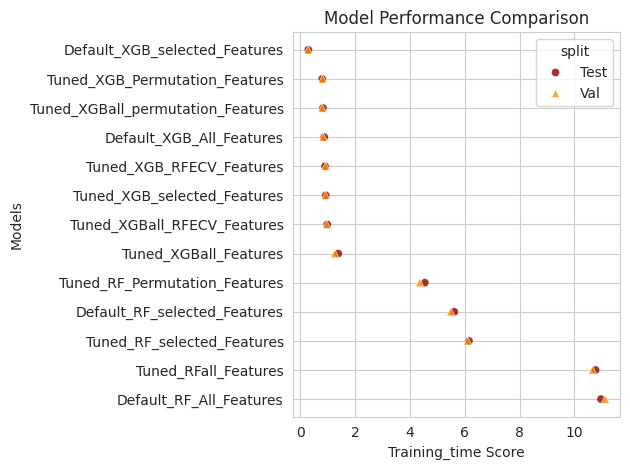

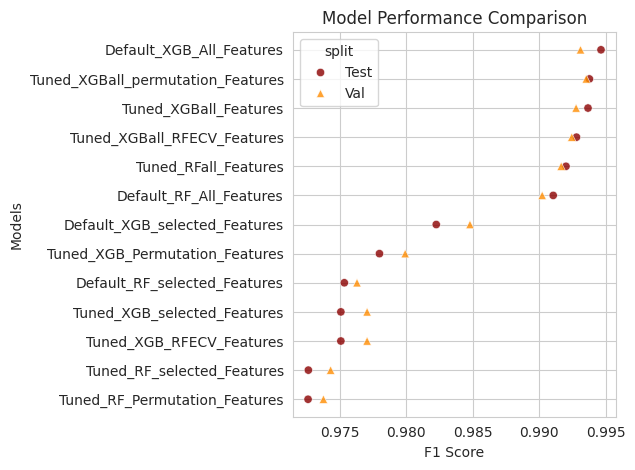

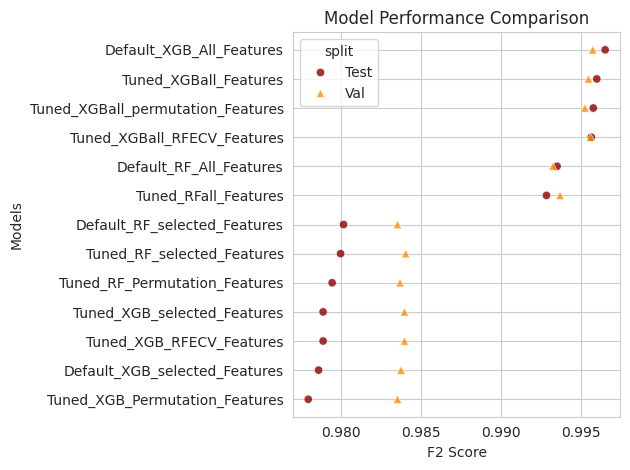

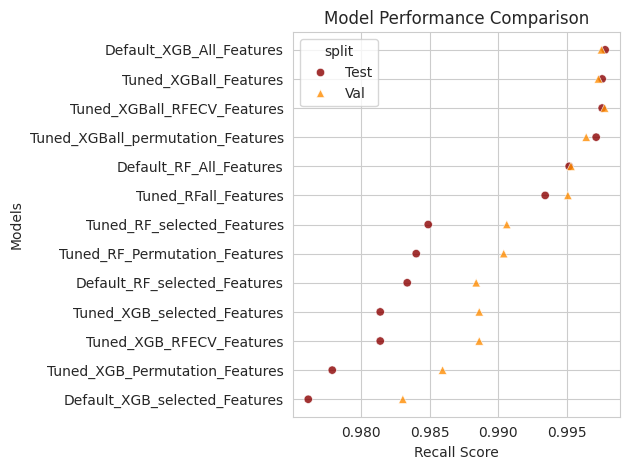

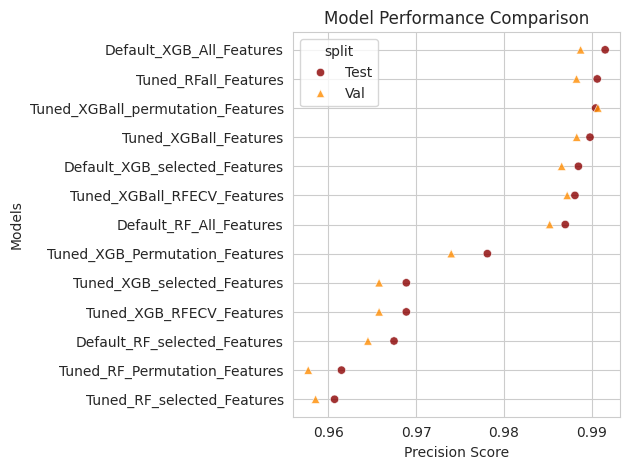

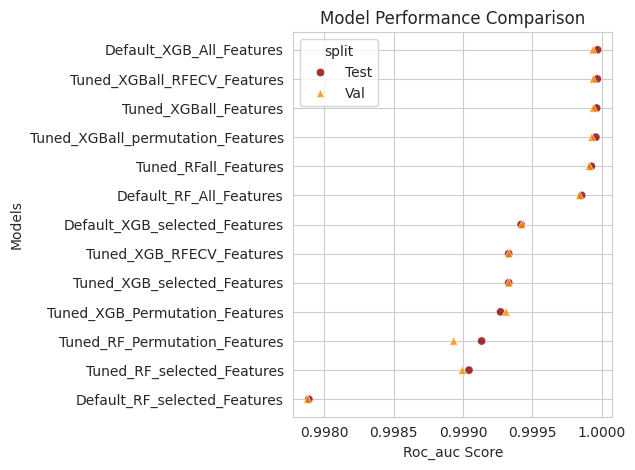

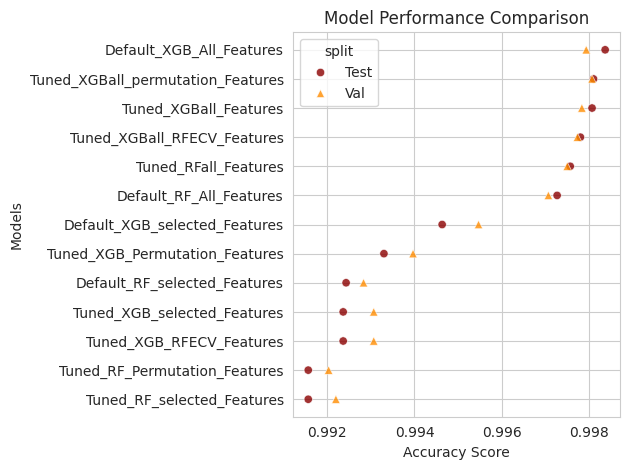

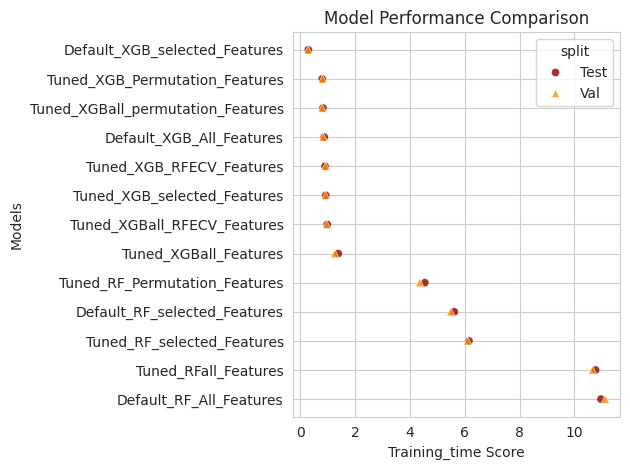

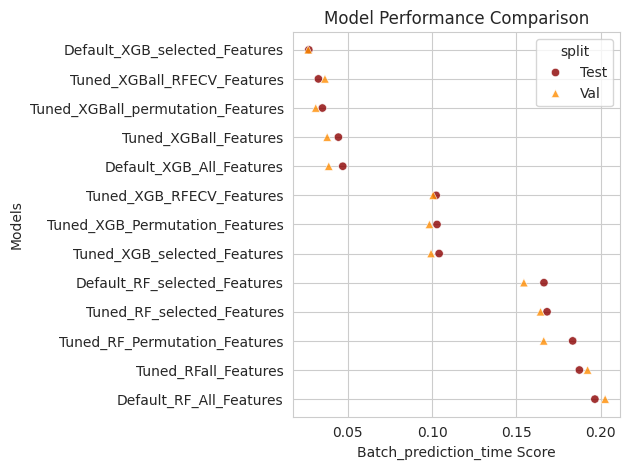

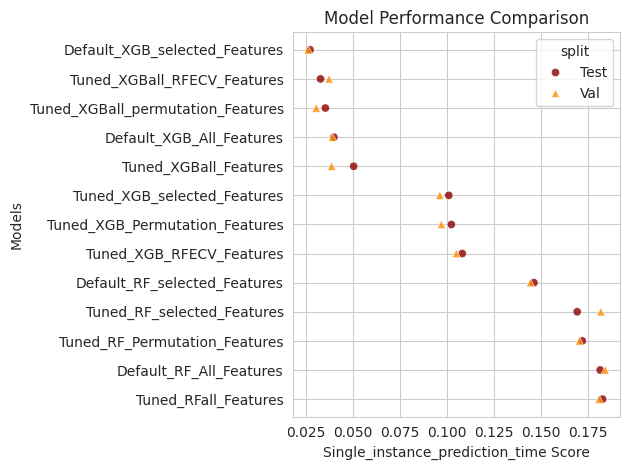

In [40]:
for m in ['training_time','f1', 'f2', 'recall', 'precision', 'roc_auc', 'accuracy','training_time', 'batch_prediction_time','single_instance_prediction_time']:
    plot_best_model_splits(df, metric = m)

In [56]:
def plot_best_model_subplots(perf_df, metrics=['f2', 'single_instance_prediction_time']):
    # Filter DataFrame for 'Test' and sort based on the first metric
    metric = metrics[0]
    if 'time' in metric:
        test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=True)
    else:
        test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=False)
        
    # Creating a list of models sorted by their test performance without duplicates
    sorted_models = test_perf['model'].drop_duplicates().tolist()
    perf_df['model_order'] = pd.Categorical(perf_df['model'], categories=sorted_models, ordered=True)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    sns.set_style('whitegrid')
    
    for ax, metric in zip(axes, metrics):
        if 'time' in metric:
            test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=True)
        else:
            test_perf = perf_df[perf_df['split'] == 'Test'].sort_values(by=metric, ascending=False)
            
        scatter_plot = sns.scatterplot(data=perf_df, 
                                       y='model_order', 
                                       x=metric, 
                                       hue='split',
                                       style='split', 
                                       markers={       # Define markers for each split
                                           'Test': 'o',
                                           'Val': '^',
                                       },
                                       palette=['darkred', 'darkorange'],
                                       alpha=0.8, 
                                       ax=ax)  # Plot on the respective subplot

        
        scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
        scatter_plot.set_ylabel('Models' if ax == axes[0] else '')
        ax.legend(loc='upper right')

    plt.tight_layout() 
    plot_path = f'../output/plots/{metrics[0]}_bestmodel_performance_subplots.jpeg'
    plt.savefig(plot_path)
    plt.show()



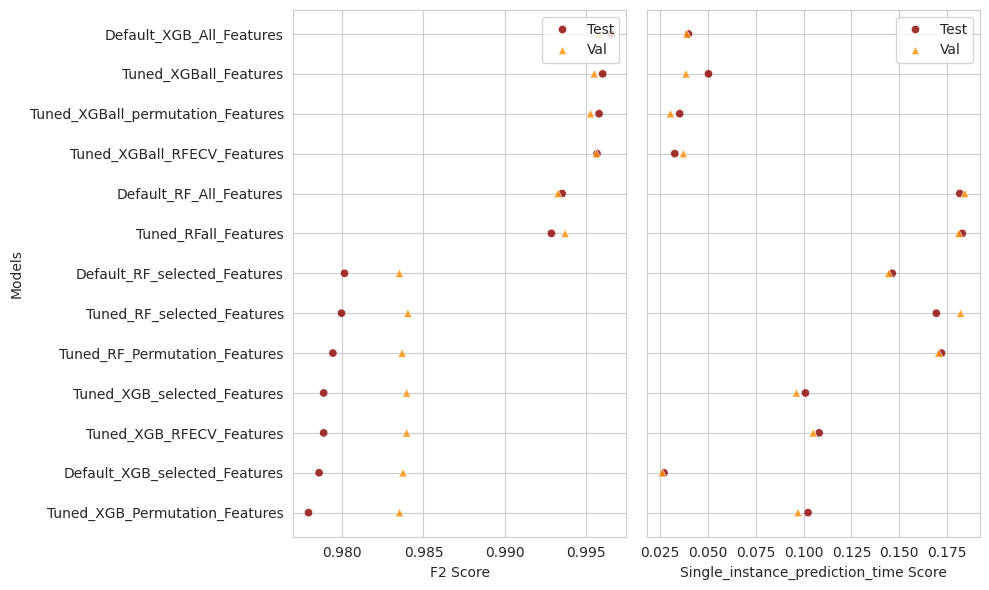

In [57]:
 plot_best_model_subplots(df, metrics=['f2', 'single_instance_prediction_time'])